## Training files

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
xgb.set_config(verbosity=1)

#
from util.Util import plot_accuracies, read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

from wordcloud import WordCloud, STOPWORDS

from rake_nltk import Rake

train_files = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [24]:
conda install -c conda-forge rake_nltk

Solving environment: done

## Package Plan ##

  environment location: /Users/sebastianbitsch/opt/anaconda3

  added / updated specs:
    - rake_nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nltk_data-2019.07.04       |       h694c41f_3       428.1 MB  conda-forge
    rake_nltk-1.0.6            |     pyhd8ed1ab_0          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:       428.1 MB

The following NEW packages will be INSTALLED:

  nltk_data          conda-forge/osx-64::nltk_data-2019.07.04-h694c41f_3
  rake_nltk          conda-forge/noarch::rake_nltk-1.0.6-pyhd8ed1ab_0



rake_nltk-1.0.6      | 13 KB     | ##################################### | 100% 
nltk_data-2019.07.04 | 428.1 MB  | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Execut

In [2]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:22, 85230.14it/s]


In [3]:
# Read the cleaned dataframe
full_df = read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords_stemmed'
vectorizer = TfidfVectorizer(max_features=250)
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)


In [5]:
stopwords = set(STOPWORDS)

def word_cloud(data, title = None):
    cloud = WordCloud(background_color = "black",
      max_words=50,
      max_font_size=40, 
      scale=3,).generate(str(data))
    fig = plt.figure(figsize= (15, 15))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)

    plt.imshow(cloud)
    plt.show()

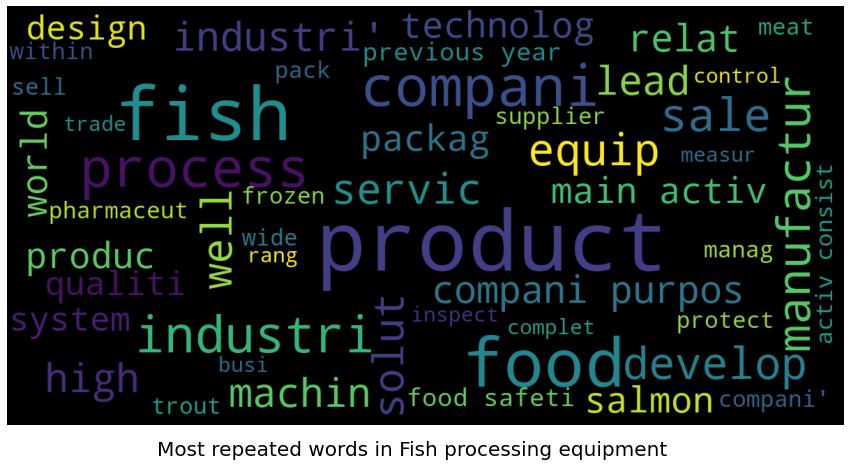

In [10]:
file_name = train_files[3]
dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
word_cloud(dfc.dff.documents('description_no_stopwords_stemmed'), f"Most repeated words in {file_name}")

In [14]:
def plot_cloud(ax, data, title):
    cloud = WordCloud(
        background_color = "black",
        max_words=50,
        max_font_size=40, 
        scale=3,).generate(str(data)
    )
    ax.imshow(cloud)

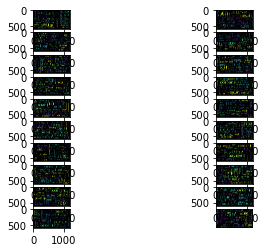

In [21]:
fig, axs = plt.subplots(nrows=10, ncols=2)
plt.axis("off")

data = dfc.dff.documents('description_no_stopwords_stemmed')

for i,ax in enumerate(axs.flat):
    file_name = train_files[i]
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    data = dfc.dff.documents('description_no_stopwords_stemmed')
    plot_cloud(ax, data, f"Most repeated words in {file_name}")

In [ ]:
stopwords = set(STOPWORDS)

def word_cloud(data, title = None):
    cloud = WordCloud(background_color = "black",
      max_words=50,
      max_font_size=40, 
      scale=3,).generate(str(data))
    fig = plt.figure(figsize= (15, 15))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)

    plt.imshow(cloud)
    plt.show()

In [47]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()

In [51]:
import pandas as pd

vocab = vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

print(reverse_vocab)
print(vocab)

feature_names = vectorizer.get_feature_names()

df_tfidf = pd.DataFrame(X, columns = feature_names)
idx = X.argsort(axis=1)
tfidf_max10 = idx[:,-3:]
df_tfidf['top_terms'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]
df_tfidf
# response = vectorizer.transform(["This is a test of how well it works"])

# feature_array = np.array(vectorizer.get_feature_names())
# tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]


# top_n = feature_array[tfidf_sorting]
# top_n

{8: 'this', 3: 'is', 6: 'the', 2: 'first', 1: 'document', 5: 'second', 0: 'and', 7: 'third', 4: 'one'}
{'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}


,and,document,first,is,one,second,the,third,this,top_terms
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085,"[this, document, first]"
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089,"[this, second, document]"
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104,"[and, one, third]"
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085,"[this, document, first]"


AttributeError: 'list' object has no attribute 'get'

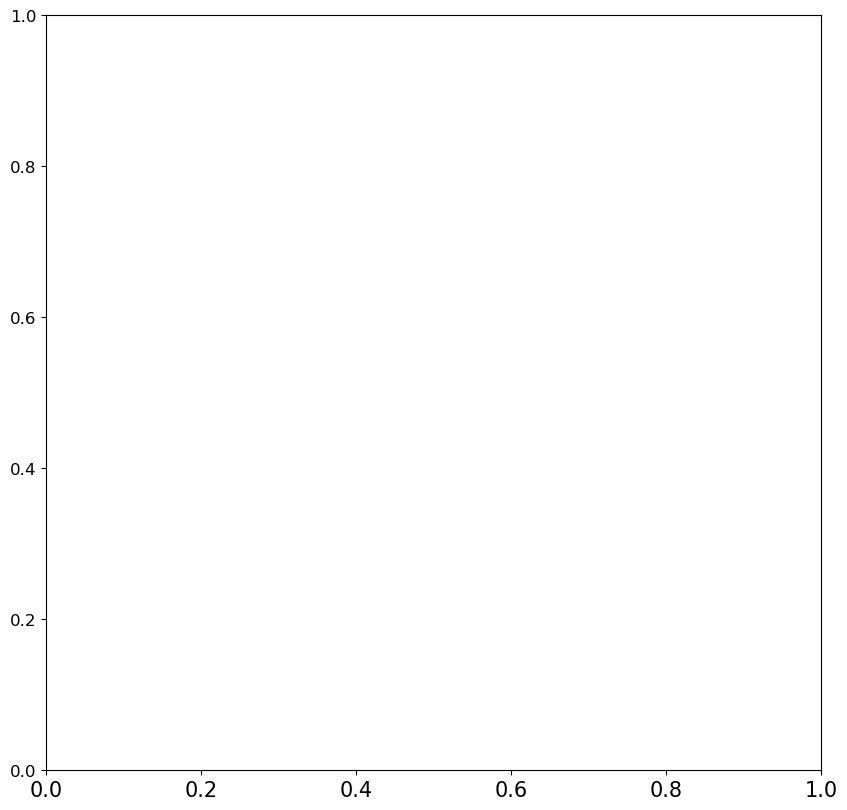

In [25]:
# Distribution of keywords in real and fake tweets 
plt.figure(figsize = (10, 10), dpi = 100)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
sns.countplot(y = "keyword", hue = "target", data = data)
plt.legend(loc = 1)
plt.show()

In [52]:
from rake_nltk import Rake

In [13]:
rake_nltk_var = Rake()

# text = """spaCy is an open-source software library for advanced natural language processing,
# written in the programming languages Python and Cython. The library is published under the MIT license
# and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion."""
# text = "this is a test"
# rake_nltk_var.extract_keywords_from_text(text)
# phrases = rake_nltk_var.get_ranked_phrases()
# print(phrases)

text = "cipherstone technologies computer vision and machine learning consultancy services "
rake_nltk_var.extract_keywords_from_text(text)
phrases = rake_nltk_var.get_ranked_phrases()
print([x for xs in phrases for x in xs.split()])
print(phrases)
#print([x for x in y for y in phrases])


['machine', 'learning', 'consultancy', 'services', 'cipherstone', 'technologies', 'computer', 'vision']
['machine learning consultancy services', 'cipherstone technologies computer vision']
